# Part A

In [34]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

In [2]:
emails = pd.read_csv("enron_practical_sample.csv")
emails

,text,label
0,"hello scott ,\nyour request is complete as fol...",ham
1,this will clear your inbox\nof spam and porn !...,spam
2,team :\nwe are fast approaching our june 1 dat...,ham
3,here are the current issues related to var and...,ham
4,"to all women ,\nif your not satisfied with you...",spam
...,...,...
1995,thanks for clarifying that vince .\nvince j ka...,ham
1996,- - - - - - - - - - - - - - - - - - - - - - - ...,ham
1997,greetings\nintruducing m i\nenjoy these great ...,spam
1998,"yes , i sent a reply to gillian .\n- - stinson",ham


In [93]:
train_text, test_text = train_test_split(emails)

train_labels = train_text['label']
train_text = train_text['text'].str.strip()
test_labels = test_text['label']
test_text = test_text['text'].str.strip()

In [107]:
vectoriser = TfidfVectorizer(stop_words="english", ngram_range=(1, 5), min_df=5, max_df=0.9)
X_train = vectoriser.fit_transform(train_text)

In [108]:
# Vocabulary size
vocab_size = len(vectoriser.vocabulary_)
print(f"Vocabulary size: {vocab_size}")

# Top 10 weighted terms (highest IDF scores)
idf_series = pd.Series(vectoriser.idf_, index=vectoriser.get_feature_names_out())
top_10_terms = idf_series.nlargest(10)
print("\nTop 10 weighted terms:")
print(top_10_terms)

Vocabulary size: 9175

Top 10 weighted terms:
00 08                 6.522127
00 10                 6.522127
000 000 individual    6.522127
000 cash              6.522127
000 company           6.522127
000 day               6.522127
000 individual        6.522127
000 little            6.522127
002                   6.522127
01 01                 6.522127
dtype: float64


# Part B

In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer
import umap
import matplotlib.pyplot as plt
import seaborn as sns

In [112]:
# Combine all text for visualization
all_text = pd.concat([train_text, test_text])
all_labels = pd.concat([train_labels, test_labels])

# Vectorize with moderate feature budget
vectoriser = TfidfVectorizer(max_features=1000, stop_words="english")
X_tfidf = vectoriser.fit_transform(all_text)

# Reduce to 2D with UMAP
reducer = umap.UMAP(n_components=2, random_state=2025, n_neighbors=50)
embedding = reducer.fit_transform(X_tfidf)

C:\Users\ryanw\Documents\GitHub\Uni-Work\MRes\Teaching\comp-wk10\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


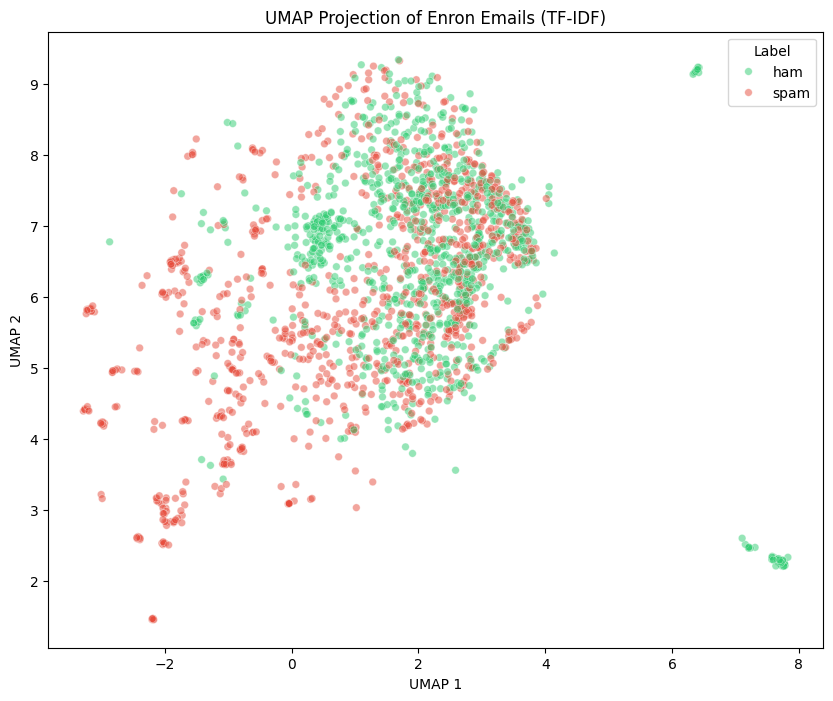

In [113]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=all_labels, palette=["#2ecc71", "#e74c3c"], alpha=0.5, s=30)
plt.title("UMAP Projection of Enron Emails (TF-IDF)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Label")
plt.show()

# Part C

In [141]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

In [131]:
pipeline = Pipeline([("vectoriser", TfidfVectorizer(max_features=1000, stop_words="english", min_df=5, max_df=0.8, ngram_range=(1, 2))),
                     ("model", LogisticRegression(max_iter=500))])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2025)

metrics = cross_validate(pipeline, train_text, train_labels,
                         cv=cv, scoring=["accuracy", "f1_macro"],
                         return_train_score=True)

In [132]:
metrics["test_f1_macro"].mean() 

np.float64(0.9505722572688304)

In [135]:
pipeline.fit(train_text, y=train_labels)

,steps,"[('vectoriser', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [192]:
predictions = pipeline.predict(test_text)
probabilities = pipeline.predict_proba(test_text)

acc = pipeline.score(test_text, y=test_labels, scoring='accuracy')
f1 = pipeline.score(test_text, y=test_labels, scoring='f1_macro')

confusion_matrix(test_labels, predictions)

array([[240,  18],
       [  4, 238]])

# Part D

In [153]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import Bunch
import numpy as np

best_params = {
    "max_features": 1000,
    "stop_words": "english",
    "min_df": 5, 
    "max_df": 0.8, 
    "ngram_range": (1, 2)
}

In [145]:
def train_with_c(C=1.0, penalty="l2") -> Bunch:
    pipeline = Pipeline([("vectoriser", TfidfVectorizer(**best_params)),
                         ("model", LogisticRegression(max_iter=1000, C=C, penalty=penalty,
                                                      solver="liblinear" if penalty == "l1" else "lbfgs"))])
    
    pipeline.fit(train_text, train_labels)
    return Bunch(pipeline=pipeline,
                 coefficients=pipeline.named_steps["model"].coef_[0],
                 vocab=pipeline.named_steps["vectoriser"].get_feature_names_out())

In [155]:
C_trials = [0.1, 1, 10, 1]
penalties = ['l2', 'l2', 'l2', 'l1']

plot_labels = ['C=0.1\np=l2', 'C=1\np=l2', 'C=10\np=l2', 'C=1\np=l1']

bunches = []

for i, [c, penalty] in enumerate(zip(C_trials, penalties)):
    print(i)
    bunches.append(train_with_c(C=c, penalty=penalty))

0
1
2
3


In [150]:
bunches[0]

{'pipeline': Pipeline(steps=[('vectoriser',
                  TfidfVectorizer(max_df=0.8, max_features=1000, min_df=5,
                                  ngram_range=(1, 2), stop_words='english')),
                 ('model', LogisticRegression(C=0.1, max_iter=1000))]),
 'coefficients': array([-2.76244558e-01, -5.73053374e-02,  6.36656386e-02, -3.63363500e-01,
        -2.94160144e-01, -1.60922766e-01, -1.87282237e-01, -5.71340116e-02,
        -1.40980915e-01, -1.39879694e-02, -1.12499334e-01, -1.44531689e-01,
        -1.65565246e-01, -1.77335844e-03, -6.84521631e-02,  2.39597465e-01,
        -2.67815319e-01, -7.41614419e-02, -3.39658775e-01, -1.48903759e-01,
        -1.36343958e-01, -1.01145545e-01, -1.06547050e-01, -7.74102382e-02,
         5.43348867e-03, -2.46813359e-02, -2.62307359e-02,  3.21859058e-02,
        -5.79092299e-01, -1.52166826e-02, -7.91239036e-01, -1.05371136e-01,
         3.43081231e-02,  1.16453614e-01,  2.79345403e-01,  2.89003634e-01,
        -4.46089335e-02, -7.311

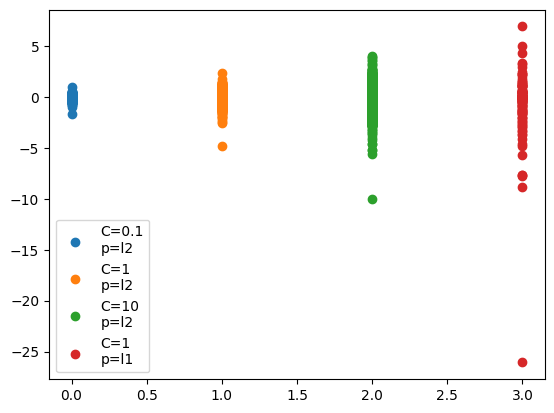

In [156]:
fig, ax = plt.subplots()

for i in range(4):
    ax.scatter(i * np.ones(1000), bunches[i]['coefficients'], label=plot_labels[i])
ax.legend()

In [157]:
winner = bunches[-1]

In [163]:
sorted_inds = np.argsort(winner['coefficients']).flatten()

lowest_inds = sorted_inds[:5]
highest_inds = sorted_inds[-5:]

lowest_coeffs = winner['coefficients'][lowest_inds]
lowest_values = winner['vocab'][lowest_inds]

highest_coeffs = winner['coefficients'][highest_inds]
highest_values = winner['vocab'][highest_inds]

print(lowest_coeffs, lowest_values)
print(highest_coeffs, highest_values)

[-26.07871949  -8.84221151  -7.7877638   -7.69445037  -7.6139047 ] ['enron' '2001' 'attached' 'vince' 'let know']
[3.25768619 3.36190271 4.34909034 5.02151467 6.95715216] ['stop' '2005' 'company' 'money' 'http']


# Part E

In [199]:
probabilities

array([[0.98979322, 0.01020678],
       [0.89874097, 0.10125903],
       [0.86502551, 0.13497449],
       [0.78337875, 0.21662125],
       [0.99178826, 0.00821174],
       [0.0717972 , 0.9282028 ],
       [0.76593237, 0.23406763],
       [0.65770878, 0.34229122],
       [0.11547972, 0.88452028],
       [0.80112407, 0.19887593],
       [0.13030713, 0.86969287],
       [0.7633421 , 0.2366579 ],
       [0.77593215, 0.22406785],
       [0.38032395, 0.61967605],
       [0.09763045, 0.90236955],
       [0.37169153, 0.62830847],
       [0.15771815, 0.84228185],
       [0.1733667 , 0.8266333 ],
       [0.13876571, 0.86123429],
       [0.47996449, 0.52003551],
       [0.9250124 , 0.0749876 ],
       [0.1815833 , 0.8184167 ],
       [0.94026806, 0.05973194],
       [0.22037541, 0.77962459],
       [0.7794945 , 0.2205055 ],
       [0.77955319, 0.22044681],
       [0.48789088, 0.51210912],
       [0.55585488, 0.44414512],
       [0.22068641, 0.77931359],
       [0.85343672, 0.14656328],
       [0.

In [209]:
misclass_inds = predictions != test_labels.values

prob_spam = np.array(probabilities[misclass_inds])[:, 1]

misclassifications = pd.DataFrame({'text': test_text[misclass_inds],
                                  'true_label': test_labels.values[misclass_inds],
                                  'predicted': predictions[misclass_inds],
                                  'probability': prob_spam}).reset_index()
misclassifications

,index,text,true_label,predicted,probability
0,401,u . s . utility and non - utility power direct...,ham,spam,0.520036
1,856,act _ flow is from our system . cp & l flow is...,ham,spam,0.512109
2,229,how bout this one .,ham,spam,0.614497
3,888,mahonia transaction is one way margin only bec...,ham,spam,0.580482
4,1171,"dear vincent kaminski ,\nwelcome to energy new...",ham,spam,0.779560
5,1533,- - - - - original message - - - - -\nfrom : l...,ham,spam,0.522086
6,1768,janet wallis\nkyle lilly\nhoward camp\ncarlos ...,ham,spam,0.573071
7,1217,"r 3 mov 3\nlisa montgomery , 36 , of melvern ,...",spam,ham,0.479735
8,63,"hi all ,\ni just got off the phone with the be...",ham,spam,0.591580
9,707,congrats sal - very very well deserved .\nyou ...,ham,spam,0.573322
